# Load and install module

In [8]:
!pip install ultralytics torch torchvision
!pip install yt-dlp


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 580.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


ModuleNotFoundError: No module named 'google.colab'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Masked-fer2013/train/surprise/31978_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/31983_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/31998_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32004_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/3201_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32031_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32035_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32040_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32057_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32061_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32079_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32096_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32098_surgical.jpg  
  inflating: Masked-fer2013/train/surprise/32099_surgical.jpg  
  inflating: Masked-fer2013/train/sur

In [10]:
import pandas as pd
import numpy as np
import os, random
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shutil
from PIL import Image
import yt_dlp

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

In [11]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [12]:
import shutil
def delete_folder(directory_path):
#     directory_path = '/kaggle/working/downloaded_video'
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"{directory_path} has been deleted.")
    else:
        print(f"{directory_path} does not exist.")

# delete_folder('/kaggle/working/runs/classify/yolov8s_emotions_unmask_classification')
# delete_folder('/kaggle/working/runs/classify/yolov8s_emotions_classification')

# Data Acquition

## FER 2013

In [13]:
emotions = {
    0:"angry",
    1:"disgust",
    2:"fear",
    3:"happy",
    4:"sad",
    5:"surprise",
    6:"neutral"
}

In [14]:
df_fer_2013 = pd.read_csv('fer2013.csv')
df_fer_2013.head()

emotion  \
0        0   
1        0   
2        2   
3        4   
4        6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
df_fer_2013[df_fer_2013['Usage'] == 'PrivateTest'].count()
# df_fer_2013['Usage'].unique()

emotion    3589
pixels     3589
Usage      3589
dtype: int64

In [16]:
df_fer_2013['labels'] = df_fer_2013['emotion'].apply(lambda x: emotions[x].lower())
df_fer_2013['Usage'] = df_fer_2013['Usage'].apply(lambda x: x.lower())
df_fer_2013.head()

emotion  \
0        0   
1        0   
2        2   
3        4   
4        6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

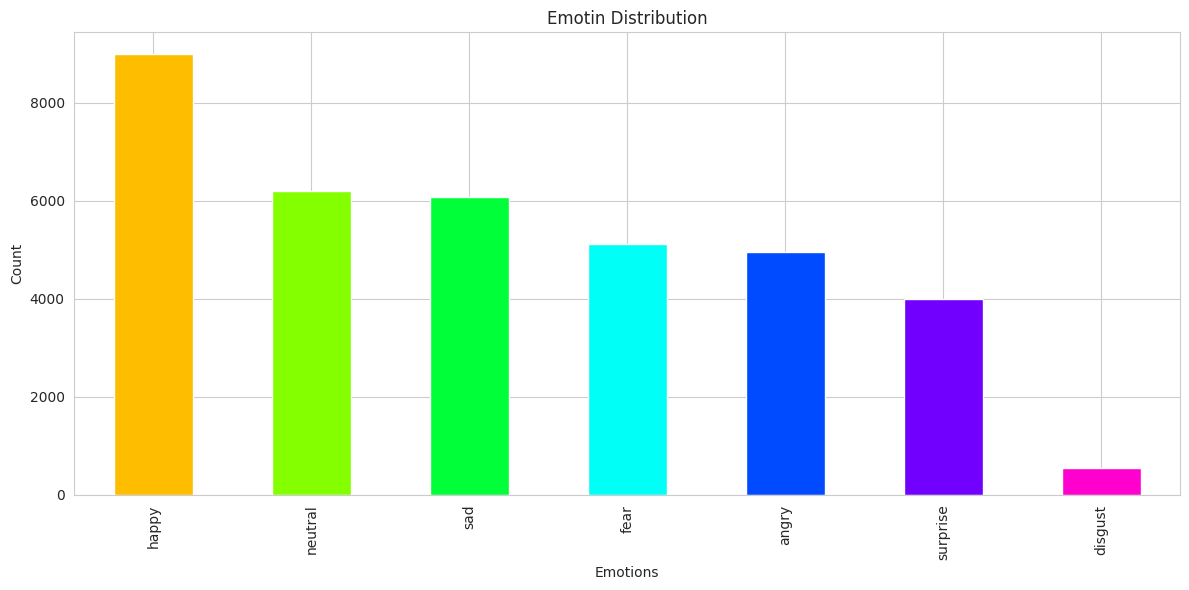

In [17]:
emotion_counts = df_fer_2013['labels'].value_counts()

colors = sns.color_palette('hsv', len(emotion_counts))

# Plotting Simpulan distribution
plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color=colors)
plt.title('Emotin Distribution')
plt.xlabel('Emotions')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [18]:
scaler = StandardScaler()

pixels = df_fer_2013["pixels"].astype(str).str.split(" ").tolist()
pixels = np.uint8(pixels)
pixels = scaler.fit_transform(pixels)
pixels = pixels.reshape((35887, 48, 48,1))

In [19]:
labels = df_fer_2013['labels'].tolist()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)


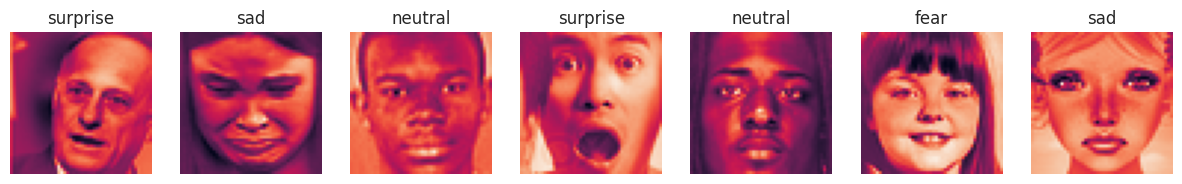

In [21]:
i= 1

plt.figure(figsize=(15,23))
for i in range (7):
    img = np.squeeze(X_train[i])
    print(img.shape)
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    plt.title(y_train[i])
    plt.axis('off')
    i += 1
plt.show()

In [29]:
def make_new_folder(name):
    if not os.path.exists(name):
        os.mkdir(name)

    return True

def delete_folder(directory_path):
#     directory_path = '/kaggle/working/downloaded_video'
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"{directory_path} has been deleted.")
    else:
        print(f"{directory_path} does not exist.")

def save_img(data, label, typically_file='train'):
    #branch center
    new_folder = f'./emotions_unmask'
    branch_type_folder = f'{new_folder}/{typically_file}'
    make_new_folder(new_folder)

    # branch type folder train, test or val
    make_new_folder(branch_type_folder)

    idx = 0

    for i in range(len(data)):
        # branch class
        branch_class_folder = f'{branch_type_folder}/{label[i]}'
        make_new_folder(branch_class_folder)

        img = np.squeeze(data[i])

        output_folder = f'{branch_class_folder}/unmask-{label[i]}-{i}.jpg'
        plt.imsave(output_folder, img)

        idx += 1

        if i == 1000:
            print(f'finished {int(1000*idx)}')

In [30]:
save_img(X_train, y_train, 'train')
save_img(X_test, y_test, 'test')
save_img(X_val, y_val, 'val')

finished 1001000
finished 1001000
finished 1001000


## Masked FER 2013

In [31]:
emotions = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral"
}

In [33]:
def link_recursive(path):
    df = pd.DataFrame()

    directories_path = os.listdir(path)

    for root, directories, files in os.walk(path):
        setFiles = [f'{root}/{file}' for file in files]

        df_loop = pd.DataFrame({'paths': setFiles})
        df = pd.concat([df, df_loop], axis=0)

    return df

def take_label(path):
    emotion = [emot.lower() for emot in list(emotions.values())]
    emotion = next((emot for emot in emotion if emot in path), None)
    return emotion.lower()

def save_img(data, label, typically_file='train'):
    #branch center
    new_folder = f'./emotions_mask'
    branch_type_folder = f'{new_folder}/{typically_file}'
    make_new_folder(new_folder)

    # branch type folder train, test or val
    make_new_folder(branch_type_folder)

    idx = 0
    start_idx = len(df_fer_2013)

    for i in range(len(data)):
        # branch class
        branch_class_folder = f'{branch_type_folder}/{label[i]}'
        make_new_folder(branch_class_folder)

        img = cv.imread(data[i])

        if img is None:
            print(f"Image Not Found: {data[i]}")
            continue

        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_normalized = img / 255.0

        output_folder = f'{branch_class_folder}/mask-{label[i]}-{int(start_idx+i)}.jpg'
        plt.imsave(output_folder, img_normalized)

        idx += 1

        if i == 1000:
            print(f'Finished {1000*idx}')

In [34]:
df = link_recursive('./Masked-fer2013')
df.head()

,paths
0,./Masked-fer2013/validation/angry/27770_surgical.jpg
1,./Masked-fer2013/validation/angry/16510_surgical.jpg
2,./Masked-fer2013/validation/angry/33729_surgical.jpg
3,./Masked-fer2013/validation/angry/30415_surgical.jpg
4,./Masked-fer2013/validation/angry/7793_surgical.jpg


In [35]:
!pwd

/home/muslima/PycharmProjects/AI


In [36]:
df['labels'] = df['paths'].apply(lambda x: take_label(x))
df['labels'].unique()

array(['angry', 'surprise', 'sad', 'neutral', 'happy'], dtype=object)

In [37]:
df['paths'].tolist(), df['labels'].tolist()

(['./Masked-fer2013/validation/angry/27770_surgical.jpg',
  './Masked-fer2013/validation/angry/16510_surgical.jpg',
  './Masked-fer2013/validation/angry/33729_surgical.jpg',
  './Masked-fer2013/validation/angry/30415_surgical.jpg',
  './Masked-fer2013/validation/angry/7793_surgical.jpg',
  './Masked-fer2013/validation/angry/29085_surgical.jpg',
  './Masked-fer2013/validation/angry/251_surgical.jpg',
  './Masked-fer2013/validation/angry/12842_surgical.jpg',
  './Masked-fer2013/validation/angry/19060_surgical.jpg',
  './Masked-fer2013/validation/angry/6075_surgical.jpg',
  './Masked-fer2013/validation/angry/22089_surgical.jpg',
  './Masked-fer2013/validation/angry/3599_surgical.jpg',
  './Masked-fer2013/validation/angry/4579_surgical.jpg',
  './Masked-fer2013/validation/angry/4468_surgical.jpg',
  './Masked-fer2013/validation/angry/20629_surgical.jpg',
  './Masked-fer2013/validation/angry/14120_surgical.jpg',
  './Masked-fer2013/validation/angry/19268_surgical.jpg',
  './Masked-fer2013/v

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['paths'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [39]:
save_img(X_train, y_train, 'train')
save_img(X_test, y_test, 'test')
save_img(X_val, y_val, 'val')

Finished 1001000
Finished 1001000
Finished 1001000


# Data Preparation and modeling

In [40]:
def count_images_per_class(generator):
    class_counts = {class_name: 0 for class_name in generator.class_indices}

    for i in range(len(generator.classes)):
        class_index = generator.classes[i]
        class_name = list(generator.class_indices.keys())[class_index]
        class_counts[class_name] += 1

    return class_counts

def visualize_per_class(categories, values):
    colors = sns.color_palette('hsv', len(categories))
    plt.bar(categories, values, color=colors)
    plt.xlabel('Category')
    plt.ylabel('Amount')
    plt.title('Correct Counts Data')
    plt.show()

Found 22967 images belonging to 7 classes.


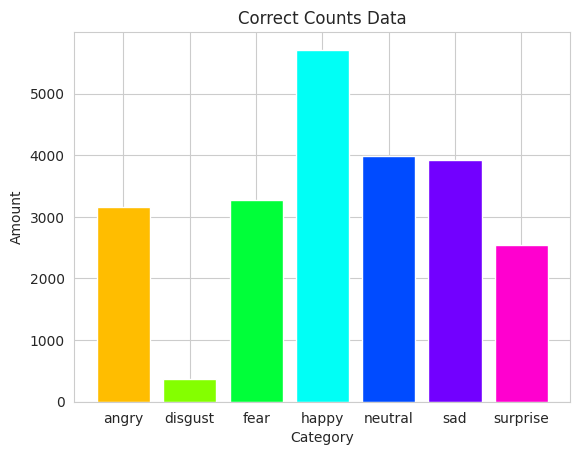

In [41]:
paths = './emotions_unmask/train'
original_data = ImageDataGenerator(rescale=1./255)
train_data = original_data.flow_from_directory(paths, target_size = (224, 224), batch_size = 32, class_mode="categorical", shuffle=False)

train_class_counts = count_images_per_class(train_data)
visualize_per_class(train_class_counts.keys(), train_class_counts.values())

Found 22967 images belonging to 7 classes.


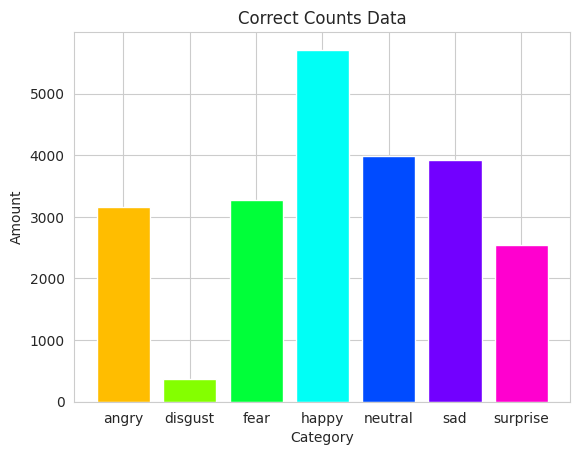

In [42]:
paths = './emotions_unmask/train'
original_data = ImageDataGenerator(rescale=1./255)
train_data = original_data.flow_from_directory(paths, target_size = (224, 224), batch_size = 32, class_mode="categorical", shuffle=False)

train_class_counts = count_images_per_class(train_data)
visualize_per_class(train_class_counts.keys(), train_class_counts.values())

In [43]:
imgs, labels = next(train_data)
class_indices = train_data.class_indices
decoded_class_indices = {v: k for k, v in class_indices.items()}
decoded_class_indices

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

# modeling

In [44]:
patience = 5
factor = 0.5
min_lr = 1e-4

class ReduceLROnPlateauCallback:
    def __init__(self, patience=5, factor=0.5, min_lr=1e-6):
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_loss = float('inf')
        self.num_bad_epochs = 0

    def on_epoch_end(self, model):
        val_loss = model.metrics['val']['loss']

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            for param_group in model.optimizer.param_groups:
                new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                param_group['lr'] = new_lr
            print(f"Reducing learning rate to {new_lr:.6f}")
            self.num_bad_epochs = 0

class EarlyStoppingCallback:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
        self.should_stop = False

    def __call__(self, model):
        val_loss = model.metrics['val']['loss']

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print("Early stopping triggered")
            self.should_stop = True
            model.stop_training = True

In [45]:
reduce_lr_callback = ReduceLROnPlateauCallback(patience=patience, factor=factor, min_lr=min_lr)
early_stopping_callback = EarlyStoppingCallback(patience=patience)

In [46]:
model_unmask = YOLO('yolov8s-cls.pt')
model_unmask.add_callback('on_epoch_end', reduce_lr_callback)
model_unmask.add_callback('on_epoch_end', early_stopping_callback)

train_config = {
    'data': './emotions_unmask',
    'name': 'yolov8s_emotions_unmask_classification',
    'epochs': 50,
    'batch': 32,
    'imgsz': 48,
    'optimizer': 'AdamW',
    'weight_decay': 0.0005,
    'mosaic': 1.0,
    'mixup': 0.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'flipud': 0.0,
    'fliplr': 0.5
}

model_unmask.train(**train_config)

New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.105 🚀 Python-3.11.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=./emotions_unmask, epochs=50, time=None, patience=100, batch=32, imgsz=48, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_emotions_unmask_classification3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

train: Scanning /home/muslima/PycharmProjects/AI/emotions_unmask/train... 22967 images, 0 corrupt: 100%|██████████| 22967/22967 [00:00<?, ?it/s]
val: Scanning /home/muslima/PycharmProjects/AI/emotions_unmask/val... 5742 images, 0 corrupt: 100%|██████████| 5742/5742 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to runs/classify/yolov8s_emotions_unmask_classification3
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 66.94it/s]

                   all      0.477      0.963



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 70.85it/s]

                   all       0.48       0.96



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 70.99it/s]

                   all      0.466      0.969



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:03<00:00, 28.83it/s]

                   all      0.512       0.97



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 68.24it/s]

                   all      0.512       0.97



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:02<00:00, 36.62it/s]


                   all      0.545      0.973

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 54.76it/s]

                   all      0.549      0.978



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 50.77it/s]

                   all      0.551      0.976



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 65.52it/s]

                   all      0.553      0.974



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.314G      1.286         23         64: 100%|██████████| 718/718 [00:45<00:00, 15.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:02<00:00, 44.60it/s]

                   all      0.564       0.98



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.314G      1.272         23         64: 100%|██████████| 718/718 [00:31<00:00, 22.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:02<00:00, 34.10it/s]

                   all       0.57      0.978



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.314G      1.256         23         64: 100%|██████████| 718/718 [00:40<00:00, 17.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 70.02it/s]

                   all      0.575       0.98



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.314G       1.24         23         64: 100%|██████████| 718/718 [00:38<00:00, 18.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 59.10it/s]

                   all      0.583      0.978



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.314G      1.236         23         64: 100%|██████████| 718/718 [00:31<00:00, 22.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:02<00:00, 33.73it/s]

                   all      0.587      0.981



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.314G      1.227         23         64: 100%|██████████| 718/718 [00:34<00:00, 20.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 45.42it/s]

                   all      0.587       0.98



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.314G      1.212         23         64: 100%|██████████| 718/718 [00:33<00:00, 21.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 66.26it/s]

                   all      0.588      0.981



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.346G      1.196         23         64: 100%|██████████| 718/718 [00:32<00:00, 22.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 45.35it/s]


                   all        0.6      0.982

      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.346G      1.184         23         64: 100%|██████████| 718/718 [00:37<00:00, 18.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:03<00:00, 29.26it/s]

                   all      0.601      0.984



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.346G      1.179         23         64: 100%|██████████| 718/718 [00:35<00:00, 19.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:01<00:00, 64.52it/s]

                   all      0.606      0.982



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.346G      1.169         23         64: 100%|██████████| 718/718 [00:33<00:00, 21.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 104.70it/s]

                   all        0.6      0.983



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.346G      1.154         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.47it/s]

                   all      0.609      0.983



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.346G      1.144         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.54it/s]

                   all      0.609      0.984



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.346G      1.136         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.74it/s]

                   all      0.618      0.987



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.346G      1.123         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.43it/s]

                   all      0.615      0.985



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.346G      1.118         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.21it/s]

                   all       0.62      0.987



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.346G      1.108         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.86it/s]

                   all      0.619      0.987



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.346G      1.107         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.11it/s]

                   all      0.615      0.987



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.346G      1.084         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.41it/s]

                   all      0.617      0.987



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.346G      1.091         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.94it/s]

                   all      0.621      0.987



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.346G      1.077         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.19it/s]

                   all      0.626      0.987



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.346G      1.075         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.23it/s]

                   all      0.628      0.987



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.346G      1.058         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.95it/s]

                   all      0.626      0.987



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.346G      1.046         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.58it/s]

                   all      0.625      0.986



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.346G       1.04         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.08it/s]

                   all      0.629      0.986



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.346G      1.038         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.65it/s]

                   all       0.63      0.987



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.346G      1.016         23         64: 100%|██████████| 718/718 [00:18<00:00, 39.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 100.79it/s]

                   all       0.63      0.988



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.346G       1.01         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.19it/s]

                   all      0.634      0.987



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.346G      1.002         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.84it/s]

                   all      0.636      0.987



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.346G     0.9966         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.07it/s]

                   all      0.636      0.987



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.346G     0.9931         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.00it/s]

                   all      0.639      0.987



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.346G     0.9799         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.22it/s]

                   all       0.64      0.987



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.346G      0.973         23         64: 100%|██████████| 718/718 [00:17<00:00, 39.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.93it/s]

                   all      0.639      0.987



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.346G     0.9594         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.25it/s]

                   all      0.641      0.987



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.346G     0.9495         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.15it/s]

                   all      0.641      0.987



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.346G     0.9437         23         64: 100%|██████████| 718/718 [00:17<00:00, 39.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.46it/s]

                   all      0.643      0.987



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.346G     0.9347         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.17it/s]

                   all       0.64      0.987



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.346G     0.9309         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.93it/s]

                   all      0.641      0.987



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.346G     0.9287         23         64: 100%|██████████| 718/718 [00:17<00:00, 39.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.99it/s]

                   all      0.642      0.987



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.346G     0.9203         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 102.45it/s]

                   all      0.642      0.987



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.346G     0.9213         23         64: 100%|██████████| 718/718 [00:17<00:00, 40.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 103.08it/s]

                   all      0.643      0.987



50 epochs completed in 0.359 hours.
Optimizer stripped from runs/classify/yolov8s_emotions_unmask_classification3/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/yolov8s_emotions_unmask_classification3/weights/best.pt, 10.3MB

Validating runs/classify/yolov8s_emotions_unmask_classification3/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,084,167 parameters, 0 gradients, 12.5 GFLOPs
train: /home/muslima/PycharmProjects/AI/emotions_unmask/train... found 22967 images in 7 classes ✅ 
val: /home/muslima/PycharmProjects/AI/emotions_unmask/val... found 5742 images in 7 classes ✅ 
test: /home/muslima/PycharmProjects/AI/emotions_unmask/test... found 7178 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 90/90 [00:00<00:00, 110.85it/s]


                   all      0.596       0.97
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolov8s_emotions_unmask_classification3


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x77e0103ba890>
curves: []
curves_results: []
fitness: 0.7830024361610413
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5959596037864685, 'metrics/accuracy_top5': 0.970045268535614, 'fitness': 0.7830024361610413}
save_dir: PosixPath('runs/classify/yolov8s_emotions_unmask_classification3')
speed: {'preprocess': 0.005259289794596441, 'inference': 0.12778886276560922, 'loss': 7.694949508206086e-05, 'postprocess': 0.000140081504499709}
task: 'classify'
top1: 0.5959596037864685
top5: 0.970045268535614

In [47]:
model_mask = YOLO('yolov8s-cls.pt')
model_mask.add_callback('on_epoch_end', reduce_lr_callback)
model_mask.add_callback('on_epoch_end', early_stopping_callback)

train_config = {
    'data': './emotions_mask',
    'name': 'yolov8s_emotions_mask_classification',
    'epochs': 50,
    'batch': 32,
    'imgsz': 48,
    'optimizer': 'AdamW',
    'weight_decay': 0.0005
}

model_mask.train(**train_config)

New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.105 🚀 Python-3.11.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=./emotions_mask, epochs=50, time=None, patience=100, batch=32, imgsz=48, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_emotions_mask_classification2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning /home/muslima/PycharmProjects/AI/emotions_mask/train... 13660 images, 0 corrupt: 100%|██████████| 13660/13660 [00:00<?, ?it/s]
val: Scanning /home/muslima/PycharmProjects/AI/emotions_mask/val... 3416 images, 0 corrupt: 100%|██████████| 3416/3416 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to runs/classify/yolov8s_emotions_mask_classification2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 101.95it/s]

                   all      0.533          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 106.27it/s]

                   all       0.54          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 105.64it/s]

                   all      0.531          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.79it/s]

                   all      0.566          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 105.10it/s]


                   all      0.596          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.29it/s]

                   all       0.59          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.89it/s]


                   all      0.622          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.33it/s]


                   all      0.625          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.27it/s]


                   all      0.615          1

      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.455G      1.017         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.48it/s]


                   all      0.615          1

      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.455G      1.014         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.01it/s]


                   all      0.622          1

      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.455G      1.005         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.13it/s]


                   all      0.602          1

      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.455G       0.99         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.49it/s]

                   all      0.651          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.455G     0.9769         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.74it/s]

                   all      0.648          1

      Epoch    GPU_mem       loss  Instances       Size



      15/50     0.455G     0.9746         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.67it/s]


                   all      0.616          1

      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.455G     0.9739         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.32it/s]


                   all      0.648          1

      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.455G     0.9712         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.04it/s]


                   all      0.654          1

      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.455G     0.9607         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.25it/s]


                   all      0.649          1

      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.455G     0.9499         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.00it/s]

                   all      0.661          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.455G     0.9407         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.09it/s]


                   all      0.655          1

      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.455G     0.9337         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.95it/s]


                   all      0.665          1

      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.455G      0.928         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.93it/s]


                   all      0.665          1

      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.455G     0.9288         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.10it/s]

                   all      0.664          1

      Epoch    GPU_mem       loss  Instances       Size



      24/50     0.455G      0.916         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 101.54it/s]

                   all      0.668          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.455G     0.9117         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.82it/s]

                   all      0.672          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.455G     0.9069         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.22it/s]


                   all      0.674          1

      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.455G     0.9051         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.97it/s]


                   all      0.671          1

      Epoch    GPU_mem       loss  Instances       Size


      28/50      0.48G     0.9048         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.01it/s]


                   all      0.672          1

      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.482G     0.8932         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.81it/s]


                   all      0.676          1

      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.482G     0.8879         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.83it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.482G     0.8836         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.80it/s]

                   all      0.685          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.482G     0.8779         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.86it/s]


                   all      0.674          1

      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.482G     0.8698         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.46it/s]

                   all      0.677          1

      Epoch    GPU_mem       loss  Instances       Size



      34/50     0.482G     0.8665         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.76it/s]

                   all      0.679          1

      Epoch    GPU_mem       loss  Instances       Size



      35/50     0.482G     0.8562         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.91it/s]

                   all      0.682          1

      Epoch    GPU_mem       loss  Instances       Size



      36/50     0.482G     0.8525         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.13it/s]


                   all      0.689          1

      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.482G     0.8437         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.64it/s]


                   all      0.688          1

      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.482G     0.8412         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.14it/s]


                   all      0.683          1

      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.482G     0.8365         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.81it/s]

                   all      0.687          1

      Epoch    GPU_mem       loss  Instances       Size



      40/50     0.482G     0.8292         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.03it/s]

                   all      0.691          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.482G     0.8269         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.02it/s]

                   all      0.694          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.482G      0.816         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.83it/s]

                   all      0.695          1

      Epoch    GPU_mem       loss  Instances       Size



      43/50     0.482G      0.811         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.57it/s]


                   all      0.691          1

      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.482G     0.8095         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.74it/s]


                   all      0.698          1

      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.482G     0.8025         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.52it/s]

                   all      0.697          1

      Epoch    GPU_mem       loss  Instances       Size



      46/50     0.482G     0.7974         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 102.69it/s]

                   all      0.701          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.482G     0.7902         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.77it/s]


                   all      0.698          1

      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.482G     0.7824         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 98.74it/s] 

                   all      0.699          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.482G     0.7759         28         64: 100%|██████████| 427/427 [00:10<00:00, 40.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 104.02it/s]


                   all      0.697          1

      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.482G     0.7735         28         64: 100%|██████████| 427/427 [00:10<00:00, 39.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 103.79it/s]

                   all      0.699          1

50 epochs completed in 0.157 hours.


Optimizer stripped from runs/classify/yolov8s_emotions_mask_classification2/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/yolov8s_emotions_mask_classification2/weights/best.pt, 10.3MB

Validating runs/classify/yolov8s_emotions_mask_classification2/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,081,605 parameters, 0 gradients, 12.5 GFLOPs
train: /home/muslima/PycharmProjects/AI/emotions_mask/train... found 13660 images in 5 classes ✅ 
val: /home/muslima/PycharmProjects/AI/emotions_mask/val... found 3416 images in 5 classes ✅ 
test: /home/muslima/PycharmProjects/AI/emotions_mask/test... found 4269 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 54/54 [00:00<00:00, 105.77it/s]


                   all      0.701          1
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolov8s_emotions_mask_classification2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x77dd68e2bfd0>
curves: []
curves_results: []
fitness: 0.8504098355770111
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7008196711540222, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8504098355770111}
save_dir: PosixPath('runs/classify/yolov8s_emotions_mask_classification2')
speed: {'preprocess': 0.005696152224580325, 'inference': 0.1346555553278232, 'loss': 8.247570271596402e-05, 'postprocess': 0.0001486800353570365}
task: 'classify'
top1: 0.7008196711540222
top5: 1.0

In [48]:
def visualize_model(namepath):
    data = pd.read_csv(namepath)

    plt.figure(figsize=(14, 8))

    # Loss
    plt.plot(data['epoch'], data['train/loss'], label='Train Loss', color='blue')
    plt.plot(data['epoch'], data['val/loss'], label='Validation Loss', color='orange')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

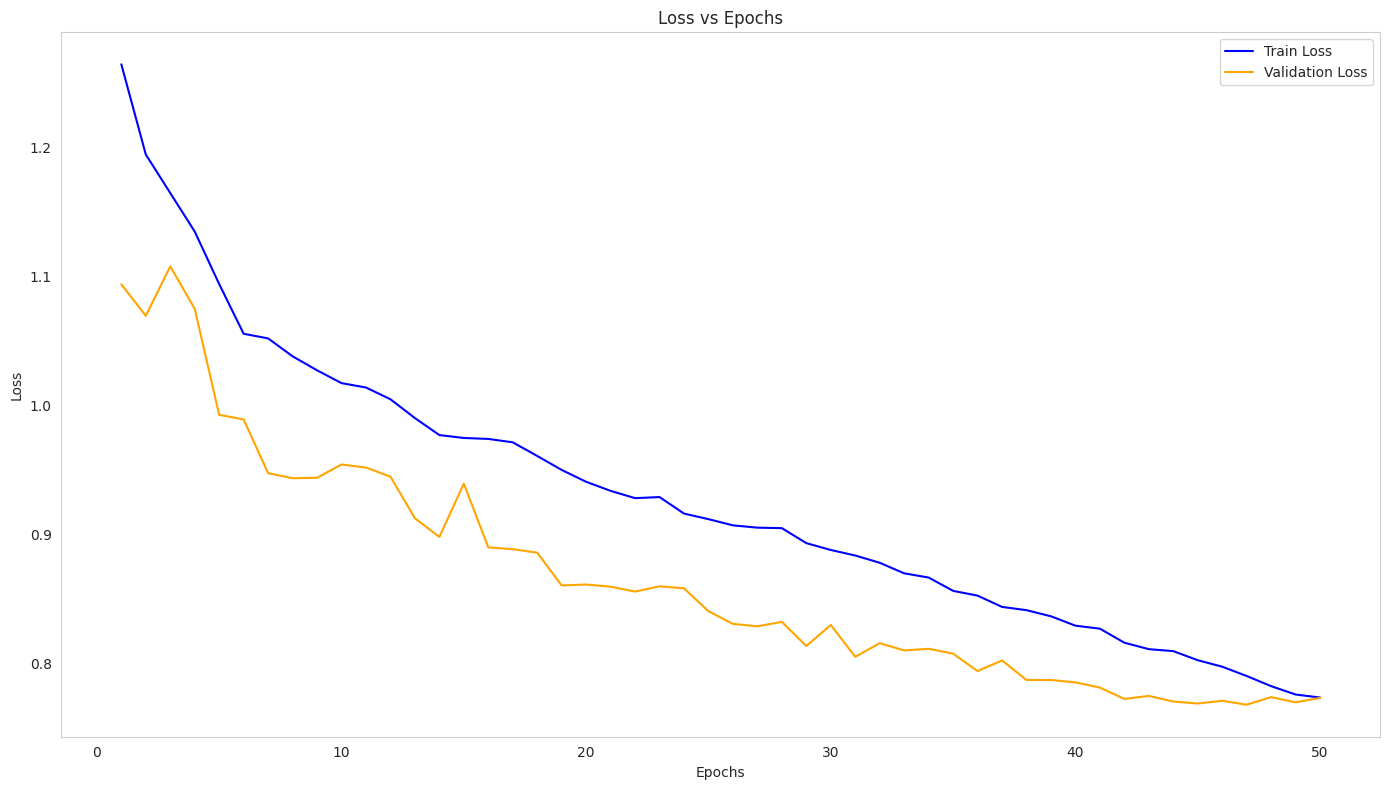

In [49]:
visualize_model('./runs/classify/yolov8s_emotions_mask_classification2/results.csv')

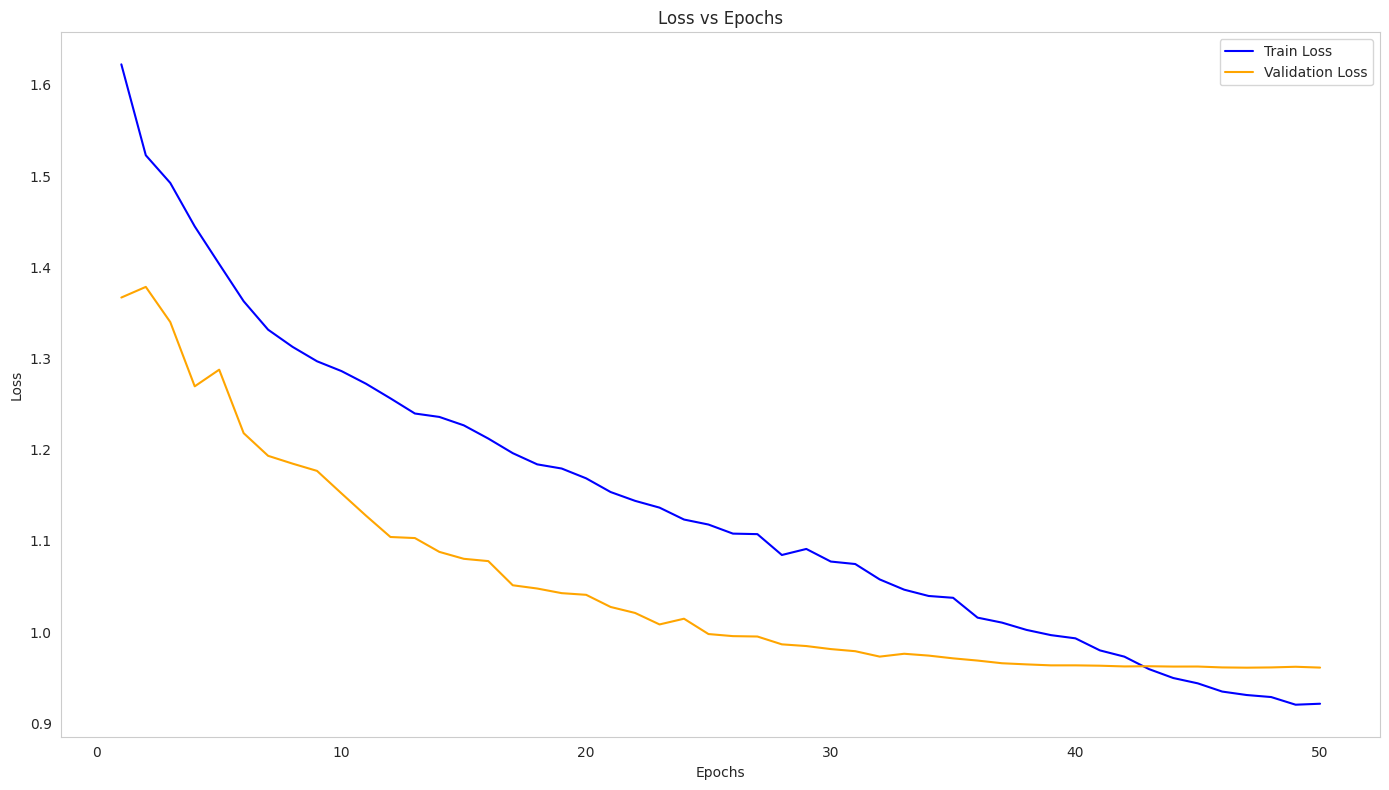

In [50]:
visualize_model('./runs/classify/yolov8s_emotions_unmask_classification3/results.csv')

## ensemble learning

In [51]:
model_expression_masking = torch.load("./runs/classify/yolov8s_emotions_mask_classification2/weights/best.pt")
model_expression_unmasking = torch.load("./runs/classify/yolov8s_emotions_unmask_classification3/weights/best.pt")

# model_expression_masking.eval()
# model_expression_unmasking.eval()

In [52]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, method='majority_vote'):
        super(EnsembleModel, self).__init__()
        self.model1 = model1['model'].cuda().half()
        self.model2 = model2['model'].cuda().half()
        self.method = method

    def forward(self, x):
        with torch.no_grad():
            # Get the output from the YOLO model.
            output1 = self.model1(x)[0]  # Output model 1
            output2 = self.model2(x)[0]  # Output model 2

            # Take the predicted probabilities from each model.
            probs1 = output1.cpu().numpy()  # Probabilities model 1
            probs2 = output2.cpu().numpy()  # Probabilities model 2

            # Check if shapes match and adjust if necessary
            num_classes = min(probs1.shape[1], probs2.shape[1])  # Minimum number of classes
            probs1 = probs1[:, :num_classes]  # Select common classes from model1
            probs2 = probs2[:, :num_classes]  # Select common classes from model2

            # Average the probabilities for each class
            probs_ensemble = (probs1 + probs2) / 2

            # Get the predicted label (classification) from the ensemble.
            pred_label = np.argmax(probs_ensemble, axis=1)  # Argmax along class dimension

            return pred_label

In [53]:
ensemble_model = EnsembleModel(model_expression_masking, model_expression_unmasking, method='average')
torch.save(ensemble_model, "./pillbox_ensemble.pt")
print("The ensemble model has been saved as 'pillbox_ensemble.pt'.")

The ensemble model has been saved as 'pillbox_ensemble.pt'.


In [54]:
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []

    for inputs, labels in dataloader:
        inputs = inputs.cuda().half()
        # labels = labels.cuda().half()  # Remove this line

        with torch.no_grad():
            pred_label = model(inputs)

            y_pred.extend(pred_label)  # Extend instead of append
            y_true.extend(labels.cpu().numpy())

    # min_len = min(len(y_true), len(y_pred))  # Remove this line
    # y_true = y_true[:min_len]              # Remove this line
    # y_pred = y_pred[:min_len]              # Remove this line

    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [62]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])
test_dataset = datasets.ImageFolder("./emotions_mask/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
ensemble_model.eval()
ensemble_model.cuda()  # Move to GPU if available.
accuracy = evaluate_model(ensemble_model, test_loader)
print(f"Ensemble model accuracy: {accuracy:.2f}")

RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

## Evaluation


In [65]:
decode_label = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral"
}

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_ensemble = './pillbox_ensemble.pt'
ensemble_model = torch.load(path_ensemble, map_location=torch.device('cpu'))
ensemble_model = ensemble_model.float()
ensemble_model.eval()

detector = YOLO('yolov5nu.pt').to(device)

In [72]:
def classify_with_ensemble(image, bbox, transform):
    x1, y1, x2, y2 = map(int, bbox.xyxy[0].tolist())
    height = y2 - y1
    width = x2 - x1

    y_head_end = y1 + int(0.40 * height)

    narrow_width = int(0.60 * width)
    x_center = (x1 + x2) // 2
    x1_narrow = max(0, x_center - narrow_width // 2)
    x2_narrow = min(image.shape[1], x_center + narrow_width // 2)

    person_crop =  image[y1:y_head_end, x1_narrow:x2_narrow]
    person_img = Image.fromarray(cv.cvtColor(person_crop, cv.COLOR_BGR2RGB))

    input_tensor = transform(person_img).unsqueeze(0)
    with torch.no_grad():
        label = 'Angry'

    color = (0, 255, 0)
    cv.rectangle(image, (x1_narrow, y1), (x2_narrow, y_head_end), color, 2)
    cv.putText(image, label, (x1_narrow, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return label, person_crop

def detect_image(image_path, detector, transform):
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    results = detector(image_rgb, conf=0.5, classes=0)

    for box in results[0].boxes:
        bbox = box.xyxy[0].cpu().numpy()
        ensemble_label, person_crop = classify_with_ensemble(image_rgb, box, transform)

        print(f"Ensemble Label: {ensemble_label}")

        plt.imshow(person_crop)
        plt.show()  # Make sure to display the image




0: 640x480 1 person, 45.6ms
Speed: 18.8ms preprocess, 45.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)
Ensemble Label: Angry


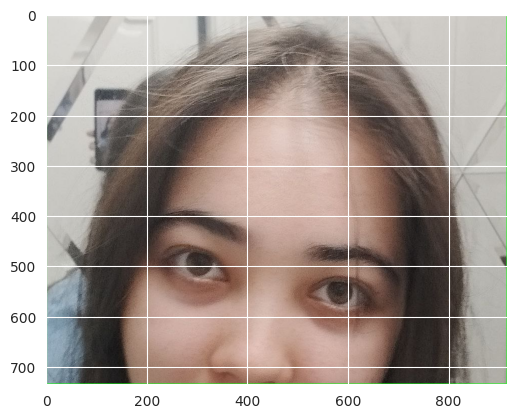

In [73]:
# image detection
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

detect_image('/home/muslima/PycharmProjects/AI/angry.jpg', detector, transform)